In [21]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"

from transformers import BertModel, BertTokenizer
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import ast
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
# Import the dataset
df = pd.read_csv("final_resume_dataset.csv")
print(df.head())

         Resume Job Role                                  Resume Experience  \
0      Market Researcher  ['Conducted surveys and focus groups to gather...   
1  Research Psychologist  ['Developed and conducted surveys to assess us...   
2      Senior Researcher  ['Assisted in the design and execution of in-d...   
3             QA Manager  ['Managed and maintained office facilities, in...   
4      Logistics Manager  ['Developed and executed space planning strate...   

                                       Resume Skills           Job Title  \
0  Market research tools and techniques User inte...     User Researcher   
1  Research methodology Usability testing with in...     User Researcher   
2  Social science research methods User testing S...     User Researcher   
3  Construction management Estate planning Enviro...  Facilities Manager   
4  Project management Server maintenance Site pla...  Facilities Manager   

                                     Job Description  \
0  Conduct u

In [3]:
# Load the bert tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [4]:
class FieldPairDataset(Dataset):
    def __init__(self, df, tokenizer, field_1, field_2, label_field, max_len=512, combine_fields=None):
        self.df = df
        self.tokenizer = tokenizer
        self.field_1 = field_1
        self.field_2 = field_2
        self.label_field = label_field
        self.max_len = max_len
        self.combine_fields = combine_fields  # optional tuple of fields to join

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Support concatenating multiple fields into input_a
        if self.combine_fields:
            input_a = " ".join(str(row[f]) for f in self.combine_fields)
        else:
            input_a = str(row[self.field_1])

        input_b = str(row[self.field_2])
        label = float(row[self.label_field])

        # Pretty-print list fields like Resume Experience
        try:
            if input_b.startswith("[") and isinstance(eval(input_b), list):
                input_b = "\n- " + "\n- ".join(ast.literal_eval(input_b))
        except:
            pass

        encoding = self.tokenizer(
            input_a,
            input_b,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.float)
        }


In [5]:
# Example usage of the dataset
# Title Match
title_dataset = FieldPairDataset(
    df,
    tokenizer,
    field_1="Job Title",
    field_2="Resume Job Role",
    label_field="Job Title Match"
)

# Skills Match
skills_dataset = FieldPairDataset(
    df,
    tokenizer,
    field_1="Job Skills",
    field_2="Resume Skills",
    label_field="Skills Match"
)

# Responsibilities Match (combining Job Description + Responsibilities)
responsibilities_dataset = FieldPairDataset(
    df,
    tokenizer,
    field_1=None,
    field_2="Resume Experience",
    label_field="Responsibilities Match",
    combine_fields=("Job Description", "Job Responsibilities")
)


In [6]:
# Make a dataloader with proper train test splits
# df = df.sample(frac=0.1, random_state=42)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Title Match
title_train_dataset = FieldPairDataset(train_df, tokenizer,
    field_1="Job Title", field_2="Resume Job Role", label_field="Job Title Match")

title_test_dataset = FieldPairDataset(test_df, tokenizer,
    field_1="Job Title", field_2="Resume Job Role", label_field="Job Title Match")

title_train_loader = DataLoader(title_train_dataset, batch_size=8, shuffle=True)
title_test_loader = DataLoader(title_test_dataset, batch_size=8, shuffle=False)

# Skills Match
skills_train_dataset = FieldPairDataset(train_df, tokenizer,
    field_1="Job Skills", field_2="Resume Skills", label_field="Skills Match")

skills_test_dataset = FieldPairDataset(test_df, tokenizer,
    field_1="Job Skills", field_2="Resume Skills", label_field="Skills Match")

skills_train_loader = DataLoader(skills_train_dataset, batch_size=8, shuffle=True)
skills_test_loader = DataLoader(skills_test_dataset, batch_size=8, shuffle=False)

# Responsibilities Match
resp_train_dataset = FieldPairDataset(train_df, tokenizer,
    field_1=None, field_2="Resume Experience", label_field="Responsibilities Match",
    combine_fields=("Job Description", "Job Responsibilities"))

resp_test_dataset = FieldPairDataset(test_df, tokenizer,
    field_1=None, field_2="Resume Experience", label_field="Responsibilities Match",
    combine_fields=("Job Description", "Job Responsibilities"))

resp_train_loader = DataLoader(resp_train_dataset, batch_size=8, shuffle=True)
resp_test_loader = DataLoader(resp_test_dataset, batch_size=8, shuffle=False)

In [7]:
# Make the model
class JobFitModel(nn.Module):
    def __init__(self):
        super(JobFitModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.ffn = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )


    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # Grab [CLS] token
        score = self.ffn(cls_embedding)
        return score.squeeze(1)  # Return shape: (batch_size,)

In [8]:
def train_model(model, train_loader, optimizer, criterion, device, epochs=3):
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
        for batch in loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} training loss: {avg_loss:.4f}")


In [9]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    print(f"Test MSE Loss: {avg_loss:.4f}")
    return all_preds, all_labels


In [10]:
def plot_predictions(preds, labels):
    plt.figure(figsize=(6, 6))
    plt.scatter(labels, preds, alpha=0.5, color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # ideal diagonal
    plt.xlabel("True Suitability Score")
    plt.ylabel("Predicted Score")
    plt.title("Predicted vs. True Suitability")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [11]:
def predict_suitability(model, tokenizer, jd_text, resume_text, device):
    model.eval()

    encoding = tokenizer(
        jd_text, resume_text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=512
    )

    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        output = model(input_ids=input_ids, attention_mask=attention_mask)

    return output.item()


In [14]:
# Setup variables
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# Setup all models
title_model = JobFitModel().to(device)
title_optimizer = torch.optim.AdamW(title_model.parameters(), lr=2e-5)
title_criterion = nn.MSELoss()

skills_model = JobFitModel().to(device)
skills_optimizer = torch.optim.AdamW(skills_model.parameters(), lr=2e-5)
skills_criterion = nn.MSELoss()

resp_model = JobFitModel().to(device)
resp_optimizer = torch.optim.AdamW(resp_model.parameters(), lr=2e-5)
resp_criterion = nn.MSELoss()


In [17]:
# Train title match model
train_model(title_model, title_train_loader, title_optimizer, title_criterion, device)

Epoch 1: 100%|██████████| 4233/4233 [11:56<00:00,  5.91it/s, loss=0.000879]


Epoch 1 training loss: 0.0015


Epoch 2: 100%|██████████| 4233/4233 [11:56<00:00,  5.91it/s, loss=0.000473]


Epoch 2 training loss: 0.0006


Epoch 3: 100%|██████████| 4233/4233 [11:55<00:00,  5.91it/s, loss=0.000278]

Epoch 3 training loss: 0.0004


In [18]:
# Train skills match model
train_model(skills_model, skills_train_loader, skills_optimizer, skills_criterion, device)

Epoch 1: 100%|██████████| 4233/4233 [12:17<00:00,  5.74it/s, loss=0.000445]


Epoch 1 training loss: 0.0030


Epoch 2: 100%|██████████| 4233/4233 [12:17<00:00,  5.74it/s, loss=0.00131]


Epoch 2 training loss: 0.0015


Epoch 3: 100%|██████████| 4233/4233 [12:17<00:00,  5.74it/s, loss=0.000851]

Epoch 3 training loss: 0.0011


In [19]:
# Train responsibilities match model
train_model(resp_model, resp_train_loader, resp_optimizer, resp_criterion, device)

Epoch 1: 100%|██████████| 4233/4233 [13:02<00:00,  5.41it/s, loss=0.00111]


Epoch 1 training loss: 0.0032


Epoch 2: 100%|██████████| 4233/4233 [13:03<00:00,  5.41it/s, loss=0.00422]


Epoch 2 training loss: 0.0014


Epoch 3: 100%|██████████| 4233/4233 [13:02<00:00,  5.41it/s, loss=0.000774]

Epoch 3 training loss: 0.0010


Test MSE Loss: 0.0002


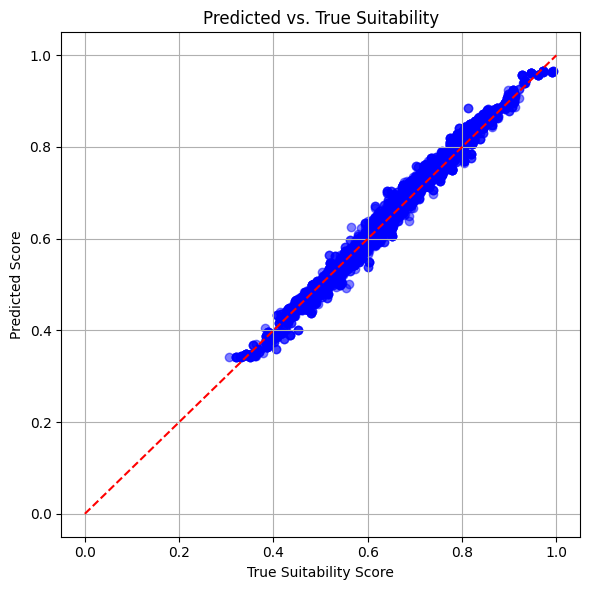

Test MSE Loss: 0.0008


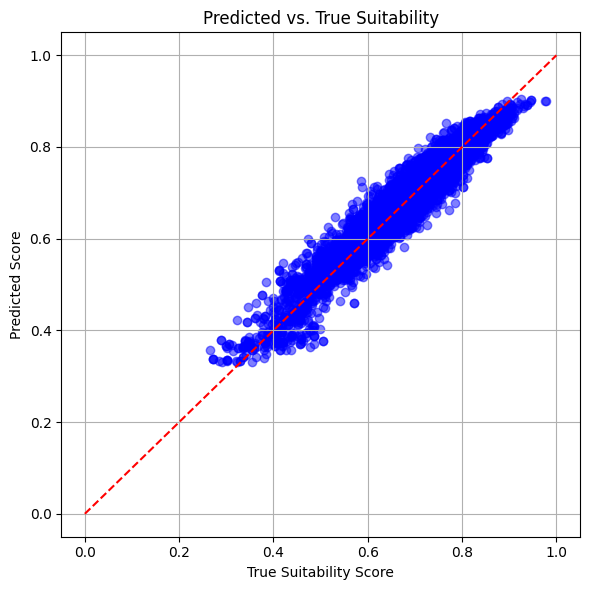

Test MSE Loss: 0.0009


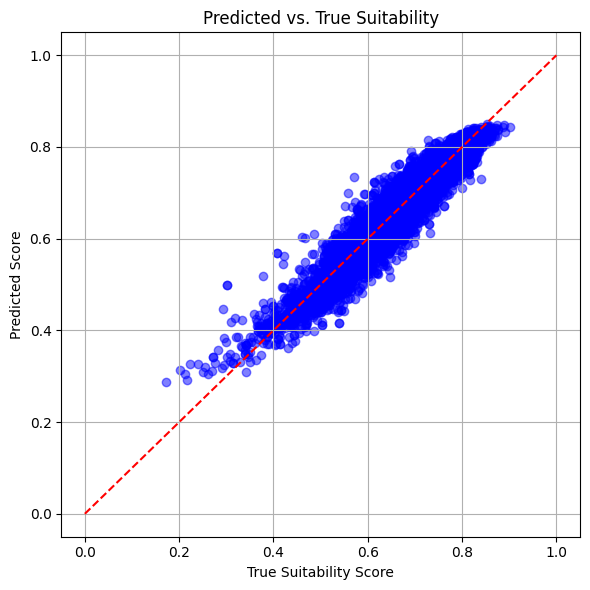

In [22]:
# Evaluate Model
# Evaluate Title Match
title_preds, title_labels = evaluate_model(title_model, title_test_loader, title_criterion, device)
plot_predictions(title_preds, title_labels)

# Evaluate Skills Match
skills_preds, skills_labels = evaluate_model(skills_model, skills_test_loader, skills_criterion, device)
plot_predictions(skills_preds, skills_labels)

# Evaluate Responsibilities Match
resp_preds, resp_labels = evaluate_model(resp_model, resp_test_loader, resp_criterion, device)
plot_predictions(resp_preds, resp_labels)


In [23]:
# Use the model
# Job Posting Fields
job_title = "User Researcher"
job_skills = "User research methods, usability testing, data analysis"
job_responsibilities = "Conduct interviews and usability studies. Synthesize user insights."
job_description = "Understand user behavior and feedback."

# Resume Fields
resume_role = "Market Researcher"
resume_skills = "Qualitative research, A/B testing, surveys"
resume_experience = "- Conducted focus groups\n- Analyzed survey data\n- Presented user insights"

# Title Match Prediction
title_score = predict_suitability(
    title_model,
    tokenizer,
    jd_text=job_title,
    resume_text=resume_role,
    device=device
)

# Skills Match Prediction
skills_score = predict_suitability(
    skills_model,
    tokenizer,
    jd_text=job_skills,
    resume_text=resume_skills,
    device=device
)

# Responsibilities Match Prediction
responsibilities_input = job_responsibilities + " " + job_description
resp_score = predict_suitability(
    resp_model,
    tokenizer,
    jd_text=responsibilities_input,
    resume_text=resume_experience,
    device=device
)
print(f"Title Match Score:           {title_score:.3f}")
print(f"Skills Match Score:          {skills_score:.3f}")
print(f"Responsibilities Match Score:{resp_score:.3f}")

overall_score = (title_score + skills_score + resp_score) / 3
print(f"\nOverall Predicted Suitability: {overall_score:.3f}")


Title Match Score:           0.610
Skills Match Score:          0.524
Responsibilities Match Score:0.564

Overall Predicted Suitability: 0.566


In [24]:
torch.save(title_model.state_dict(), "title_model.pt")
torch.save(skills_model.state_dict(), "skills_model.pt")
torch.save(resp_model.state_dict(), "resp_model.pt")
